### gpt 조언

1. 공행성 선후행 쌍 찾아내기
- 분석 Idea 예시
    - cross corr
    - granger 인과성
    - Dynamic Time Warping 기반 시차 패턴 분석
    - VAR : Vector Autoregression
    - Lasso/Graphical models

2. 해당 선후행 쌍을 기반 후행 품목의 다음달 무역량을 예측
- 분석 Idea 예시
    - OLS
    - ARIMAX
    - Prophet + 선행 품목 Feature
    - VAR / VECM 
    - RF, Light GBM
    - LSTM
    - Temporal Fusion Transformer

### 전략

1. 주어진 Base line 으로 무엇을 해야 하는지 그리고, 어떤 게 나왔는지에 대한 감을 익힌다. 
    - baseline 아무것도 안하고 내면, 0.12 대 점수... 너무 낮음

2. 각 단계 별로 제일 유명하고, 적당히 쉬운거로 일단 나의 Baseline model 을 만들고 그게 어떤 수치가 나오는지 확인한다. 
    - RF 로 예측 하는 model 바꾼 것도 0.12 대 점수 → metric 자체를 대충 봐보니 comovement pair 찾는 게 중요!

3. Baseline 이 잡힌 이후 Feature Engineering 이던지 아니면 새로운 Model 이던지 Idea 를 구상한다.
    -  정규화 후 차분 → y 를 차분한 거 histogram 으로 categorize 한 후 변화량 ( 즉 차분값)을 잘 예측하는 인자를 찾아보기?
        - 즉, 어떤 시점의 어떤 항목의 차분 값 categorize 한 걸 target 으로 삼아서, for 문으로 특정 lag를 돌면서 직전 차분 및 특정 lag 시점의 다른 모든 항목들을 다 가지고 와서 그거로 classifier 돌려보고, feature importance 로 특정 importance 이상이 되는 feature 들을 모아서 comovement 쌍이라고 한다?
        - 이거 하려면 feature 가 100개가 넘게 되네? 일단 RF 니까 된다고 치고 한 번 돌려본다?
        - 

## 1. Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## 2. 데이터 전처리

In [2]:
train = pd.read_csv('./open/train.csv')

# year, month, item_id 기준으로 value 합산 (seq만 다르다면 value 합산)
monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)

# year, month를 하나의 키(ym)로 묶기
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
)

# item_id × ym 피벗 (월별 총 무역량 매트릭스 생성)
pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)

pivot.head()

ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0
APQGTRMF,383999.0,512813.0,217064.0,470398.0,539873.0,582317.0,759980.0,216019.0,537693.0,205326.0,...,683581.0,2147.0,0.0,25013.0,77.0,20741.0,2403.0,3543.0,32430.0,40608.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0


## 2-2. EDA 파악

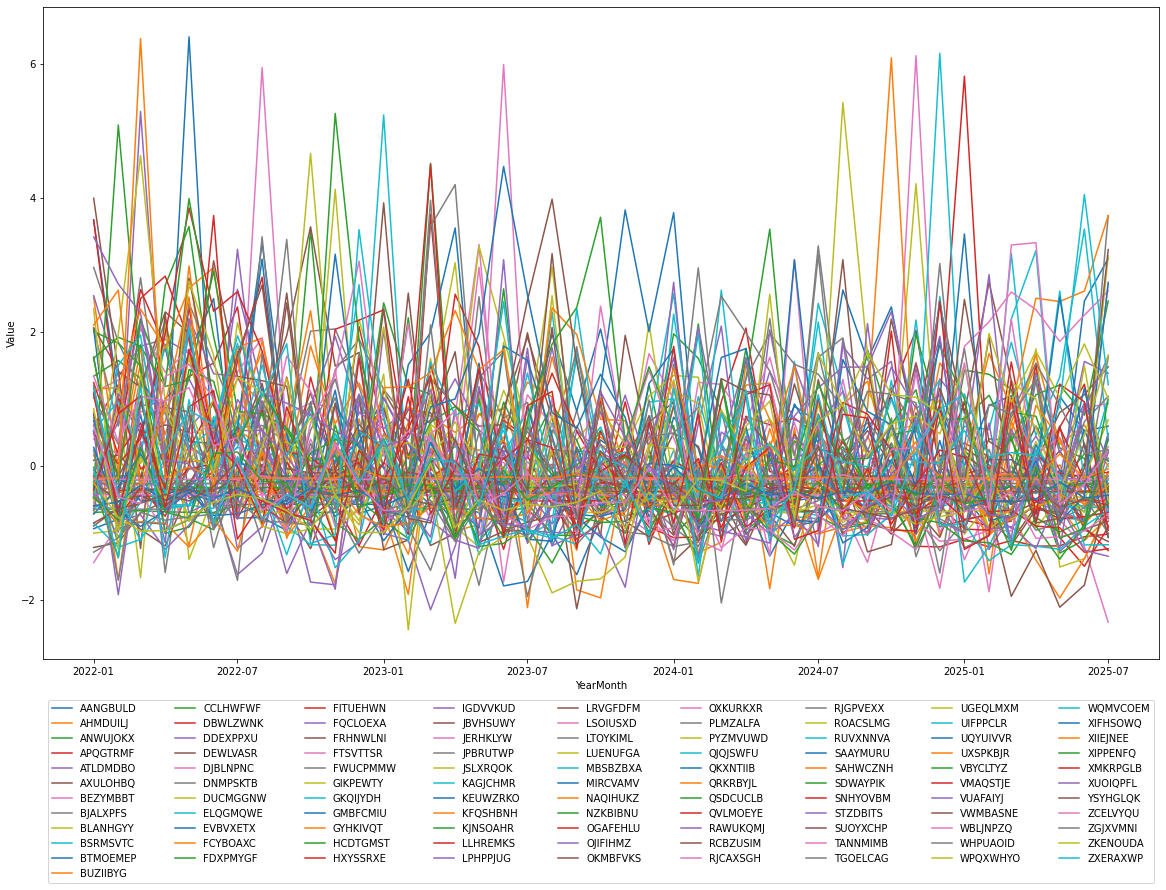

In [31]:
# line plot for each item

stdize = ((pivot.T - pivot.T.mean())/pivot.T.std()).T

def eda_lineplot(df):

    plt.figure(figsize=(20,12))

    for idx, row in df.iterrows():
        plt.plot(df.columns, row.values, label = idx)

    plt.legend(loc = 'lower center', mode='expand',ncol=9, bbox_to_anchor =(0,-0.35,1,0.5) )
    plt.xlabel("YearMonth")
    plt.ylabel("Value")
    plt.show()

eda_lineplot(stdize)

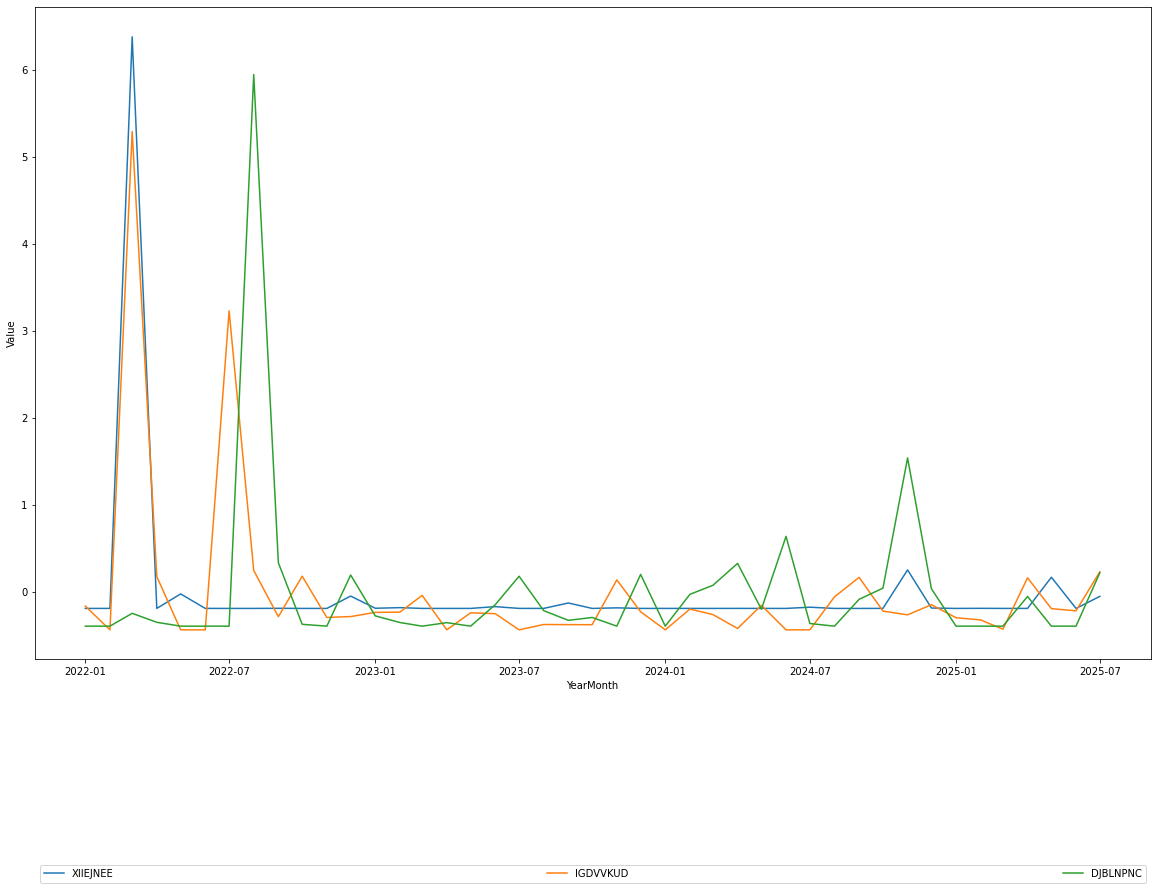

In [45]:
test = stdize.loc[['XIIEJNEE','IGDVVKUD', 'DJBLNPNC']]

eda_lineplot(test)

## 3. 공행성쌍 탐색
- 각 (A, B) 쌍에 대해 lag = 1 ~ max_lag까지 Pearson 상관계수 계산
- 절댓값이 가장 큰 상관계수와 lag를 선택
- |corr| >= corr_threshold이면 A→B 공행성 있다고 판단

### 3-0 공행성쌍 baseline 코드

In [ ]:
def safe_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

def find_comovement_pairs(pivot, max_lag=6, min_nonzero=12, corr_threshold=0.55):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            # lag = 1 ~ max_lag 탐색
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs

# 인자 조절
threshold = 0.55

pairs = find_comovement_pairs(pivot, corr_threshold=threshold)
print("탐색된 공행성쌍 수:", len(pairs))
pairs.sort_values(by= 'max_corr', key = lambda x : abs(x), ascending= False).head()

0it [00:00, ?it/s]

100it [00:08, 11.66it/s]

탐색된 공행성쌍 수: 335


,leading_item_id,following_item_id,best_lag,max_corr
300,XIIEJNEE,IGDVVKUD,4,0.928613
299,XIIEJNEE,DJBLNPNC,5,0.926700
168,NAQIHUKZ,FTSVTTSR,1,0.905093
170,NAQIHUKZ,LLHREMKS,3,0.894903
100,FTSVTTSR,LLHREMKS,2,0.884762


In [ ]:
# minmax norm 한 후에 corr 찾으면 결과가 달라지나? → 안 달라지네

minmax_norm = (pivot.T/(pivot.T.max()-pivot.T.min())).T

pairs_2 = find_comovement_pairs(minmax_norm)
print("탐색된 공행성쌍 수:", len(pairs_2))
pairs_2.sort_values(by= 'max_corr', key = lambda x : abs(x), ascending= False).head()

### 3-1. diff 및 categorize 로 찾아보기

In [ ]:
# minmax norm 후 차분 실행
diff1 = ((pivot.T - pivot.T.mean())/pivot.T.std()).T.diff(axis=1).iloc[:,1:]
diff1.head()

# qcut 을 통한 categorize 기준 bins
bins = pd.qcut(diff1.values.ravel(), q= 5, retbins=True)[1]




ym,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,0.262043,0.008273,-0.368579,0.185821,0.395719,-0.581540,0.000000,0.000000,0.000000,0.002058,...,0.796014,-1.958061,-0.810414,-0.005617,0.000785,-0.177616,0.264590,-0.264590,3.037305,0.634635
AHMDUILJ,-2.646202,1.660581,-1.545597,-1.181581,1.680950,0.813874,-0.360954,-0.639477,-1.113026,1.128596,...,-1.342775,0.442257,-1.407205,1.008661,-0.970551,1.672025,-0.909704,0.259804,-0.825057,0.257068
ANWUJOKX,0.000000,0.000000,3.088351,0.878708,-2.683533,-0.872102,-0.411424,0.000000,3.909013,-3.909013,...,0.000000,0.000000,0.000000,1.359108,-1.359108,0.000000,0.000000,0.000000,0.000000,0.000000
APQGTRMF,0.607409,-1.394573,1.194570,0.327602,0.200140,0.837751,-2.564991,1.516820,-1.567241,-0.169217,...,2.798473,-3.213230,-0.010124,0.117946,-0.117583,0.097439,-0.086471,0.005376,0.136214,0.038562
ATLDMDBO,-1.207721,0.453265,0.106019,-0.209261,-1.506519,2.459531,-1.486821,-0.770286,0.461738,-0.813550,...,0.946654,-0.920127,0.380491,0.667192,-0.787763,-0.284540,0.400122,-0.162350,-0.151387,0.761025


In [ ]:
# to do

### 밑에 build train data 를 참고해서 RF 에 쓸 수 있는 data 형태를 만들어야 함. 

array([-6.56265205, -0.6939551 , -0.07743976,  0.06930475,  0.664172  ,
        6.70622339])

## Metric Code

In [63]:
import numpy as np
import pandas as pd


def _validate_input(answer_df, submission_df):
    # ① 컬럼 개수·이름 일치 여부
    if len(answer_df.columns) != len(submission_df.columns) or not all(answer_df.columns == submission_df.columns):
        raise ValueError("The columns of the answer and submission dataframes do not match.")


    # ② 필수 컬럼에 NaN 존재 여부
    if submission_df.isnull().values.any():
        raise ValueError("The submission dataframe contains missing values.")


    # ③ pair 중복 여부
    pairs = list(zip(submission_df["leading_item_id"], submission_df["following_item_id"]))
    if len(pairs) != len(set(pairs)):
        raise ValueError("The submission dataframe contains duplicate (leading_item_id, following_item_id) pairs.")
        
def comovement_f1(answer_df, submission_df):
    """공행성쌍 F1 계산"""
    ans = answer_df[["leading_item_id", "following_item_id"]].copy()
    sub = submission_df[["leading_item_id", "following_item_id"]].copy()


    ans["pair"] = list(zip(ans["leading_item_id"], ans["following_item_id"]))
    sub["pair"] = list(zip(sub["leading_item_id"], sub["following_item_id"]))


    G = set(ans["pair"])
    P = set(sub["pair"])


    tp = len(G & P)
    fp = len(P - G)
    fn = len(G - P)


    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0


    return f1


def comovement_nmae(answer_df, submission_df, eps=1e-6):
    """
    전체 U = G ∪ P에 대한 clipped NMAE 계산
    """
    ans = answer_df[["leading_item_id", "following_item_id", "value"]].copy()
    sub = submission_df[["leading_item_id", "following_item_id", "value"]].copy()


    ans["pair"] = list(zip(ans["leading_item_id"], ans["following_item_id"]))
    sub["pair"] = list(zip(sub["leading_item_id"], sub["following_item_id"]))


    G = set(ans["pair"])
    P = set(sub["pair"])
    U = G | P


    ans_val = dict(zip(ans["pair"], ans["value"]))
    sub_val = dict(zip(sub["pair"], sub["value"]))


    errors = []
    for pair in U:
        if pair in G and pair in P:
            # 정수 변환(반올림)
            y_true = int(round(float(ans_val[pair])))
            y_pred = int(round(float(sub_val[pair])))
            rel_err = abs(y_true - y_pred) / (abs(y_true) + eps)
            rel_err = min(rel_err, 1.0) # 오차 100% 이상은 100%로 간주
        else:
            rel_err = 1.0  # FN, FP는 오차 100%
        errors.append(rel_err)


    return np.mean(errors) if errors else 1.0


def comovement_score(answer_df, submission_df):
    _validate_input(answer_df, submission_df)
    S1 = comovement_f1(answer_df, submission_df)
    nmae_full = comovement_nmae(answer_df, submission_df, 1e-6)
    S2 = 1 - nmae_full
    score = 0.6 * S1 + 0.4 * S2
    return score

## 4. 회귀 모델 학습
- 시계열 데이터 안에서 '한 달 뒤 총 무역량(value)을 맞추는 문제'로 self-supervised 학습
- 탐색된 모든 공행성쌍 (A,B)에 대해 월 t마다 학습 샘플 생성
- input X:
1) B_t (현재 총 무역량(value))
2) B_{t-1} (직전 달 총 무역량(value))
3) A_{t-lag} (lag 반영된 총 무역량(value))
4) max_corr, best_lag (관계 특성)
- target y:
1) B_{t+1} (다음 달 총 무역량(value))
- 이러한 모든 샘플을 합쳐 LinearRegression 회귀 모델을 학습

In [ ]:
def build_training_data(pivot, pairs):
    """
    공행성쌍 + 시계열을 이용해 (X, y) 학습 데이터를 만드는 함수
    input X:
      - b_t, b_t_1, a_t_lag, max_corr, best_lag
    target y:
      - b_t_plus_1
    """
    months = pivot.columns.to_list()
    n_months = len(months)

    rows = []

    for row in pairs.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        # t+1이 존재하고, t-lag >= 0인 구간만 학습에 사용
        for t in range(max(lag, 1), n_months - 1):
            b_t = b_series[t]
            b_t_1 = b_series[t - 1]
            a_t_lag = a_series[t - lag]
            b_t_plus_1 = b_series[t + 1]

            rows.append({
                "b_t": b_t,
                "b_t_1": b_t_1,
                "a_t_lag": a_t_lag,
                "max_corr": corr,
                "best_lag": float(lag),
                "target": b_t_plus_1,
            })

    df_train = pd.DataFrame(rows)
    return df_train

# df_train_model = build_training_data(pivot, pairs)
# print('생성된 학습 데이터의 shape :', df_train_model.shape)
# df_train_model.head()

생성된 학습 데이터의 shape : (12877, 6)


,b_t,b_t_1,a_t_lag,max_corr,best_lag,target
0,104852.0,313372.0,14276.0,0.640221,6.0,246652.0
1,246652.0,104852.0,52347.0,0.640221,6.0,103737.0
2,103737.0,246652.0,53549.0,0.640221,6.0,0.0
3,0.0,103737.0,0.0,0.640221,6.0,185367.0
4,185367.0,0.0,26997.0,0.640221,6.0,236201.0


In [57]:
val_idx = np.random.choice(pairs.index, size = int(len(pairs)*0.2), replace=False)

val_pairs = pairs.loc[val_idx]
train_pairs = pairs.drop(val_idx)

df_train = build_training_data(pivot, train_pairs)
print('생성된 학습 데이터의 shape :', df_train.shape)
# df_train.head()

df_val = build_training_data(pivot, val_pairs)
print('생성된 검증 데이터의 shape :', df_val.shape)

생성된 학습 데이터의 shape : (10304, 6)
생성된 검증 데이터의 shape : (2573, 6)


In [ ]:
### baseline 에서 준 OLS

# 회귀모델 학습
feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag']

train_X = df_train[feature_cols].values
train_y = df_train["target"].values

reg = LinearRegression()
reg.fit(train_X, train_y)

LinearRegression()

## 4-2. RF로 학습시켜보기

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag']

train_X = df_train[feature_cols].values
train_y = df_train["target"].values

val_X = df_val[feature_cols].values
val_y = df_val["target"].values

model = RandomForestRegressor(random_state=3141592)

param_grid = {
    'n_estimators' : [100,200,400,800],
    "max_depth" : [None, 3,5,7],
}

grid_search = GridSearchCV(
    estimator= model,
    param_grid= param_grid,
    cv = 5,
    scoring = 'neg_mean_absolute_error',
    verbose= 3
)

grid_search.fit(train_X,train_y)

print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)
print("Validation Score:", grid_search.score(val_X, val_y))

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END max_depth=None, n_estimators=100;, score=-514734.124 total time=   6.2s
[CV 2/5] END max_depth=None, n_estimators=100;, score=-369555.542 total time=   6.1s
[CV 3/5] END max_depth=None, n_estimators=100;, score=-646605.155 total time=   6.0s
[CV 4/5] END max_depth=None, n_estimators=100;, score=-388946.257 total time=   6.3s
[CV 5/5] END max_depth=None, n_estimators=100;, score=-446129.276 total time=   6.4s
[CV 1/5] END max_depth=None, n_estimators=200;, score=-519062.653 total time=  12.6s
[CV 2/5] END max_depth=None, n_estimators=200;, score=-364884.233 total time=  11.9s
[CV 3/5] END max_depth=None, n_estimators=200;, score=-641784.972 total time=  12.1s
[CV 4/5] END max_depth=None, n_estimators=200;, score=-383714.870 total time=  12.4s
[CV 5/5] END max_depth=None, n_estimators=200;, score=-446946.256 total time=  11.9s
[CV 1/5] END max_depth=None, n_estimators=400;, score=-511110.066 total time=  24.2s
[CV 

## 5. 회귀 모델 추론 및 제출(submission) 파일 생성
- 탐색된 공행성 쌍에 대해 후행 품목(following_item_id)에 대한 2025년 8월 총 무역량(value) 예측

In [62]:
def predict(pivot, pairs, reg):
    months = pivot.columns.to_list()
    n_months = len(months)

    # 가장 마지막 두 달 index (2025-7, 2025-6)
    t_last = n_months - 1
    t_prev = n_months - 2

    preds = []

    for row in tqdm(pairs.itertuples(index=False)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        # t_last - lag 가 0 이상인 경우만 예측
        if t_last - lag < 0:
            continue

        b_t = b_series[t_last]
        b_t_1 = b_series[t_prev]
        a_t_lag = a_series[t_last - lag]

        X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag)]])
        y_pred = reg.predict(X_test)[0]

        # (후처리 1) 음수 예측 → 0으로 변환
        # (후처리 2) 소수점 → 정수 변환 (무역량은 정수 단위)
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred,
        })

    df_pred = pd.DataFrame(preds)
    return df_pred

In [66]:
submission = predict(pivot, pairs, best_model)
submission.head()

335it [00:12, 25.78it/s]


,leading_item_id,following_item_id,value
0,AANGBULD,DEWLVASR,326575
1,AANGBULD,GKQIJYDH,5417004
2,AANGBULD,ZCELVYQU,154620
3,AANGBULD,ZKENOUDA,448358
4,APQGTRMF,DNMPSKTB,5856947


In [67]:
submission.to_csv('./submission/rf_base.csv', index=False)